In [43]:
# Importiert die notwendigen Bibliotheken für Dateisystem-Operationen,
# Textverarbeitung und die Erstellung von Neuronalen Netzen.
import glob
import os
import unicodedata
import string
import torch
import torch.nn as nn
import random
from sklearn.model_selection import train_test_split

# Findet alle Dateipfade, die auf ".txt" enden, im angegebenen Ordner.
all_filenames = glob.glob('./data/names/*.txt')

# Definiert das Vokabular: Alle Buchstaben des englischen Alphabets (groß und klein).
all_letters = string.ascii_letters
# Die Größe des Vokabulars, wichtig für die One-Hot-Kodierung.
n_letters = len(all_letters)

# Initialisiert leere Datenstrukturen, die später befüllt werden.
# all_categories: Eine Liste aller Sprachen (z.B. ['German', 'English', ...])
all_categories = []
# category_lines: Ein Dictionary, das jeder Sprache eine Liste von Namen zuordnet.
category_lines = {}

# Eine Hilfsfunktion, um Unicode-Zeichen in reines ASCII umzuwandeln.
# Das vereinfacht das Problem, indem Akzente und Sonderzeichen entfernt werden.
def unicode_to_ascii(s):
    return ''.join(
        # Zerlegt Zeichen in Basisbuchstaben und Akzente (z.B. "Ś" -> "S" und "´").
        c for c in unicodedata.normalize('NFD', s)
        # Entfernt die Akzente...
        if unicodedata.category(c) != 'Mn'
        # ...und behält nur Buchstaben, die in unserem Vokabular (`all_letters`) sind.
        and c in all_letters
    )

# Die Hauptschleife, die jede gefundene Sprach-Datei verarbeitet.
for filename in all_filenames:
    # Extrahiert den Dateinamen ohne Endung, um den Namen der Kategorie (Sprache) zu erhalten.
    # z.B. 'data/names/German.txt' -> 'German'
    category = os.path.splitext(os.path.basename(filename))[0]
    # Fügt die gefundene Sprache zur Liste aller Kategorien hinzu.
    all_categories.append(category)
    
    # Öffnet die Datei, liest alle Zeilen ein und teilt sie in eine Liste von Namen auf.
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    # Bereinigt jeden Namen in der Liste mit der zuvor definierten ASCII-Funktion.
    lines_ascii = [unicode_to_ascii(line) for line in lines]
    
    # Speichert die Liste der bereinigten Namen im Dictionary unter der entsprechenden Sprache.
    category_lines[category] = lines_ascii

# Zählt die Gesamtzahl der Kategorien (Sprachen). Dies bestimmt die Größe der Output-Schicht des RNNs.
n_categories = len(all_categories)

In [44]:
# Eine Hilfsfunktion, die den Index eines Buchstabens im Vokabular `all_letters` findet.
# Beispiel: letter_to_index('a') -> 0, letter_to_index('b') -> 1
def letter_to_index(letter):
    return all_letters.find(letter)

# Wandelt einen einzelnen Buchstaben in einen "One-Hot"-Tensor der Größe 1 x 52 um.
# Ein One-Hot-Tensor ist ein Vektor, der überall Nullen hat, außer an einer einzigen Stelle.
def letter_to_tensor(letter):
    # Erstellt einen Tensor gefüllt mit Nullen, mit der Form (1, n_letters).
    tensor = torch.zeros(1, n_letters)
    # Setzt das Element am Index des Buchstabens auf 1.
    # z.B. für 'b' wird das zweite Element zu 1: tensor([0., 1., 0., ...])
    tensor[0][letter_to_index(letter)] = 1
    return tensor

# Wandelt einen ganzen Namen (ein Wort) in einen 3D-Tensor der Form <anzahl_buchstaben x 1 x n_letters> um.
# Das ist im Grunde eine Liste von One-Hot-Tensoren für jeden Buchstaben im Namen.
def name_to_tensor(name):
    # Erstellt einen Tensor gefüllt mit Nullen in der passenden Form.
    tensor = torch.zeros(len(name), 1, n_letters)
    # Geht jeden Buchstaben im Namen durch...
    for i, letter in enumerate(name):
        # ...und setzt an der entsprechenden Position im Tensor die 1 für den jeweiligen One-Hot-Vektor.
        tensor[i][0][letter_to_index(letter)] = 1
    return tensor

# Wandelt einen Kategorie-Namen (z.B. 'German') in einen Tensor mit dem entsprechenden Index um.
# Dies wird für das "wahre Label" beim Training benötigt.
def category_to_tensor(category):
    # Findet den Index der Kategorie in der Liste aller Kategorien.
    li = all_categories.index(category)
    # Erstellt einen Tensor, der nur diesen Index enthält.
    # `dtype=torch.long` ist der erwartete Datentyp für die Verlustfunktion.
    return torch.tensor([li], dtype=torch.long)

In [45]:
class RNN(nn.Module):
    # Der Konstruktor, in dem die Bausteine des Netzwerks definiert werden.
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        # Die Größe der "Gedächtnis"-Schicht (des hidden state).
        self.hidden_size = hidden_size
        
        # === Das ist der Kern des RNNs ===
        # Zwei Lineare Schichten, die als Input eine Kombination aus dem
        # aktuellen Buchstaben (input_size) UND dem Gedächtnis des letzten Schrittes (hidden_size) erhalten.
        
        # Diese Schicht berechnet das Gedächtnis für den nächsten Schritt (den neuen hidden state).
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        
        # Diese Schicht berechnet die Vorhersage für den aktuellen Schritt.
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        
        # LogSoftmax als finale Aktivierungsfunktion.
        self.softmax = nn.LogSoftmax(dim=1)

    # Die forward-Methode definiert, wie die Daten bei EINEM Zeitschritt verarbeitet werden.
    def forward(self, input_tensor, hidden_tensor):
        # Der entscheidende Schritt: Der aktuelle Input und der hidden state (das Gedächtnis)
        # vom vorherigen Zeitschritt werden zu einem einzigen Tensor zusammengefügt.
        combined = torch.cat((input_tensor, hidden_tensor), 1)
        
        # Aus der Kombination wird der neue hidden state für den NÄCHSTEN Zeitschritt berechnet.
        hidden = self.i2h(combined)
        
        # Aus derselben Kombination wird die Vorhersage (Output) für den JETZIGEN Zeitschritt berechnet.
        output = self.i2o(combined)
        
        # Gib die Vorhersage UND das aktualisierte Gedächtnis zurück.
        # Das zurückgegebene "hidden" wird im nächsten Schritt wieder als "hidden_tensor" übergeben.
        return output, hidden

    # Eine Hilfsfunktion, um das Gedächtnis am Anfang einer Sequenz mit Nullen zu initialisieren.
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

In [46]:
def get_random_training_example():
    random_category = random.choice(all_categories)
    random_name = random.choice(category_lines[random_category])
    category_tensor = category_to_tensor(random_category)
    name_tensor = name_to_tensor(random_name)
    return random_category, random_name, category_tensor, name_tensor

# Führt einen kompletten Trainingsschritt für einen Namen (eine Sequenz) durch.
def train_step(category_tensor, name_tensor):
    # Zu Beginn jedes Namens wird das Gedächtnis zurückgesetzt (mit Nullen initialisiert).
    hidden = rnn.init_hidden()
    
    # Setzt die Gradienten des Optimierers auf null.
    rnn.zero_grad()

    # === Hier passiert die Rekurrenz ===
    # Die Schleife geht den Namen Buchstabe für Buchstabe durch (jeder Buchstabe ist ein Zeitschritt).
    for i in range(name_tensor.size()[0]):
        # Das Modell verarbeitet den aktuellen Buchstaben (name_tensor[i]) und den
        # hidden state vom letzten Buchstaben. Es gibt eine Vorhersage (output) und den
        # NEUEN hidden state zurück, der die Information des aktuellen Buchstabens enthält.
        # Dieser neue hidden state wird in der nächsten Iteration der Schleife wiederverwendet.
        output, hidden = rnn(name_tensor[i], hidden)

    # Nach der Schleife enthält 'output' die Vorhersage basierend auf dem LETZTEN Buchstaben,
    # der aber Informationen über alle vorherigen Buchstaben im 'hidden' state hatte.
    # Berechne den Verlust zwischen dieser finalen Vorhersage und dem wahren Label.
    loss = criterion(output, category_tensor)
    
    # Führe Backpropagation vom finalen Verlust aus durch die Zeit.
    loss.backward()
    
    # Aktualisiere die Gewichte des Modells.
    optimizer.step()

    return output, loss.item()

# Legt die Größe der versteckten Schicht (des "Gedächtnisses") des RNNs fest.
n_hidden = 128
# Erstellt eine Instanz des RNN-Modells mit den korrekten Dimensionen für Input, Hidden Layer und Output.
rnn = RNN(n_letters, n_hidden, n_categories)

# Definiert die Verlustfunktion. NLLLoss (Negative Log Likelihood Loss) wird hier verwendet,
# da die letzte Schicht unseres Modells LogSoftmax ist. Die beiden ergänzen sich.
criterion = nn.CrossEntropyLoss()
# Legt die Lernrate fest, die steuert, wie stark die Gewichte bei jedem Schritt angepasst werden.
learning_rate = 0.01
# Definiert den Optimierungsalgorithmus (hier: Stochastic Gradient Descent),
# der die Gewichte des Modells basierend auf dem berechneten Verlust aktualisiert.
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

# Konfigurationsvariablen für die Trainingsschleife.
n_iters = 100000       # Gesamtzahl der Trainingsiterationen.
print_every = 5000     # Gibt alle 5000 Iterationen den Fortschritt aus.
plot_every = 1000      # Speichert alle 1000 Iterationen den durchschnittlichen Verlust für einen Graphen.
current_loss = 0       # Akkumulator für den Verlust zwischen den Plot-Intervallen.
all_losses = []        # Eine Liste, um die durchschnittlichen Verluste für den Plot zu speichern.

# Die Haupt-Trainingsschleife, die 'n_iters' mal durchlaufen wird.
for iter in range(1, n_iters + 1):
    # Holt bei jeder Iteration ein zufälliges Trainingsbeispiel (Name und Sprache).
    # Das ist "Stochastic" Gradient Descent, da wir nicht den ganzen Datensatz auf einmal verwenden.
    category, name, category_tensor, name_tensor = get_random_training_example()
    
    # Führt einen einzelnen Trainingsschritt mit diesem Beispiel durch.
    # Dabei werden Forward-Pass, Verlustberechnung, Backward-Pass und Optimierung ausgeführt.
    output, loss = train_step(category_tensor, name_tensor)
    
    # Addiert den Verlust dieser Iteration zum laufenden Gesamtverlust.
    current_loss += loss

    # Überprüft, ob es Zeit ist, den Fortschritt auszugeben.
    if iter % print_every == 0:
        # Holt die Vorhersage des Modells (die Kategorie mit der höchsten Wahrscheinlichkeit).
        guess, guess_i = torch.max(output, 1)
        # Überprüft, ob die Vorhersage mit dem wahren Label übereinstimmt.
        correct = '✓' if all_categories[guess_i] == category else f'✗ ({category})'
        # Gibt eine formatierte Statuszeile aus.
        print(f'{iter} {iter / n_iters * 100:.0f}% Loss: {loss:.4f} Name: {name} Guess: {all_categories[guess_i]} {correct}')

    # Überprüft, ob es Zeit ist, den Verlust für den Plot zu speichern.
    if iter % plot_every == 0:
        # Speichert den Durchschnittsverlust der letzten 'plot_every' Iterationen.
        all_losses.append(current_loss / plot_every)
        # Setzt den Verlust-Akkumulator zurück für das nächste Intervall.
        current_loss = 0

5000 5% Loss: 1.4421 Name: Hiu Guess: Korean ✗ (Chinese)
10000 10% Loss: 3.1523 Name: Simon Guess: Scottish ✗ (Dutch)
15000 15% Loss: 1.5619 Name: Jorda Guess: Spanish ✓
20000 20% Loss: 1.4208 Name: Ustimovich Guess: Russian ✓
25000 25% Loss: 0.5950 Name: Delacruz Guess: Spanish ✓
30000 30% Loss: 0.6514 Name: Telis Guess: Greek ✓
35000 35% Loss: 0.5410 Name: Marquez Guess: Spanish ✓
40000 40% Loss: 1.8009 Name: Ubina Guess: Japanese ✗ (Spanish)
45000 45% Loss: 3.8781 Name: Boutros Guess: Greek ✗ (Arabic)
50000 50% Loss: 1.9231 Name: Sayegh Guess: Irish ✗ (Arabic)
55000 55% Loss: 0.0119 Name: Pispinis Guess: Greek ✓
60000 60% Loss: 0.5978 Name: Mccallum Guess: Scottish ✓
65000 65% Loss: 0.6226 Name: Kan Guess: Chinese ✓
70000 70% Loss: 1.7754 Name: Dcruz Guess: Spanish ✗ (Portuguese)
75000 75% Loss: 2.8953 Name: Denis Guess: Greek ✗ (French)
80000 80% Loss: 1.4447 Name: Hass Guess: German ✓
85000 85% Loss: 2.0128 Name: Opp Guess: German ✗ (Czech)
90000 90% Loss: 0.7745 Name: Reagan Gues

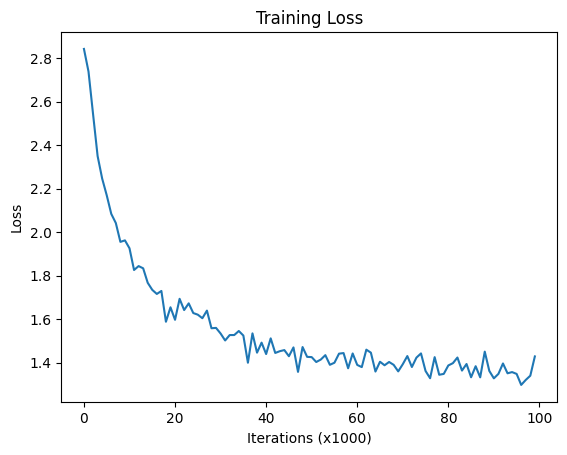

In [47]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.title('Training Loss')
plt.xlabel('Iterations (x1000)')
plt.ylabel('Loss')
plt.show()

def evaluate(name_tensor):
    rnn.eval()
    hidden = rnn.init_hidden()
    with torch.no_grad():
        for i in range(name_tensor.size()[0]):
            output, hidden = rnn(name_tensor[i], hidden)
    return output

In [48]:
def predict(input_name, n_predictions=3):
    print(f'\n> {input_name}')
    output = evaluate(name_to_tensor(input_name))
    
    topv, topi = output.topk(n_predictions, 1, True)
    
    for i in range(n_predictions):
        value = topv[0][i].item()
        category_index = topi[0][i].item()
        print(f'({value}) {all_categories[category_index]}')

predict('Rebellato')
predict('Kowalski')
predict('Satoshi')
predict('Jackson')


> Rebellato
(3.298152446746826) Portuguese
(3.1436707973480225) Italian
(1.8300763368606567) Spanish

> Kowalski
(8.00527286529541) Polish
(3.5385398864746094) Czech
(2.98399019241333) Japanese

> Satoshi
(3.0731208324432373) Italian
(1.6386618614196777) Arabic
(1.2458022832870483) Portuguese

> Jackson
(6.176233291625977) Scottish
(4.464138031005859) English
(2.533701181411743) Dutch
